In [1]:
# -- ejemplo_de_diagrama_recursos_vs_attack_rate.py --
import sys
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

# Asegúrate de que PrModelSIR.py esté en el mismo directorio o añade su ruta:
sys.path.append('PrModelSIR.py')  
import PrModelSIR as pms
from PrModelSIR import ProtectionStrategy

# ---------------- Parámetros comunes ----------------
N = 1000              # población total
infection_prob = 0.03  # probabilidad de contagio
recovery_time = 15    # pasos de recuperación
m = 4                 # parámetro para la red tipo BA
network_type = "BA"   # puede ser "BA", "ER", etc.
num_seed_nodes = 20
seed_nodes = random.sample(range(N), num_seed_nodes)

In [2]:

# Cuántas veces repetir la simulación por combinación (recursos × estrategia)
runs_per_combination = 100

# Rango de recursos que quieres evaluar:
resources_values = [0,20,40,60,80,100,200,400]
#constant to calculate lambda
lambda_number = 2

In [3]:
# Calcular lambda crítico
model_mmca_ba = pms.PrModelSIR(N, infection_prob, recovery_time, m, resources_values, seed_nodes ,model=network_type , protection_strategy= ProtectionStrategy.NO_STRATEGY)
A = np.linalg.eigvals(nx.adjacency_matrix(model_mmca_ba.network).todense()).real
mu = 1 / recovery_time
lambda_max_ba = max(A)
lambda_c_ba = mu / lambda_max_ba

lambda_ = lambda_number * lambda_c_ba 
print(lambda_)

0.007464541296275805


/var/folders/jd/rckqvbxx33q6r_78vmp56qhr0000gn/T/ipykernel_15891/2441741653.py:48: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat([


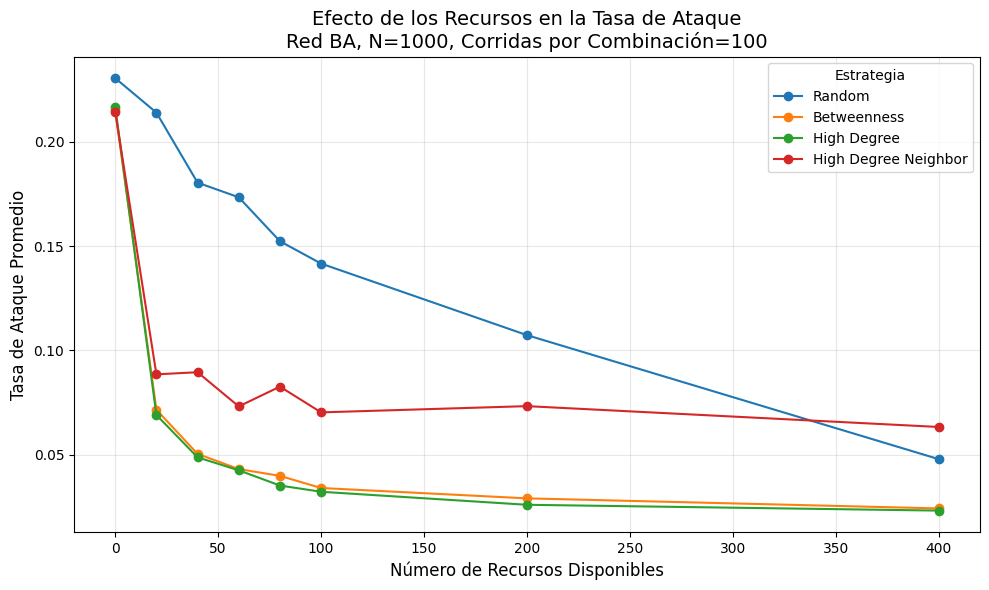

In [4]:


# Definir las estrategias a comparar
strategies = {
    #"No Strategy": ProtectionStrategy.NO_STRATEGY,
    "Random": ProtectionStrategy.RANDOM,
    "Betweenness": ProtectionStrategy.HIGH_BETWEENNESS,
    "High Degree": ProtectionStrategy.HIGH_DEGREE_NETWORK,
    "High Degree Neighbor": ProtectionStrategy.HIGH_DEGREE_NEIGHBOR
}

# DataFrame para recolectar todos los resultados
df_all = pd.DataFrame(columns=["Resources", "Strategy", "Attack Rate"])

# ----------------------------------------------------
# 1) Bucle principal: para cada nivel de recursos y cada estrategia
# ----------------------------------------------------
for R in resources_values:
    for strategy_name, strategy_enum in strategies.items():
        attack_rates = []
        
        for run_idx in range(runs_per_combination):
            # Instanciar el modelo con los parámetros correspondientes:
            model = pms.PrModelSIR(
                N,
                lambda_,
                recovery_time,
                m=m,
                model=network_type,
                protection_strategy=strategy_enum,
                resources=R,
                seed_nodes=seed_nodes
            )
            
            # Ejecutar la simulación hasta que no queden infectados (o hasta que quieras):
            df_result = model.step()
            
            # Extraer la tasa de ataque al final (attack_rate en la última fila)
            if not df_result.empty:
                tasa_final = df_result["attack_rate"].iloc[-1]
            else:
                tasa_final = 0.0
            
            attack_rates.append(tasa_final)
        
        # Promediar las tasas de ataque de todas las corridas
        promedio_attack = np.mean(attack_rates)
        
        # Agregar al DataFrame global
        df_all = pd.concat([
            df_all,
            pd.DataFrame({
                "Resources": [R],
                "Strategy": [strategy_name],
                "Attack Rate": [promedio_attack]
            })
        ], ignore_index=True)

# ----------------------------------------------------
# 2) Pivotar para facilitar la gráfica
# ----------------------------------------------------

# 1) Agrupamos por Resources y Strategy, tomando la media de Attack Rate
df_grouped = df_all.groupby(["Resources", "Strategy"], as_index=False).agg({
    "Attack Rate": "mean"
})

# 2) Ahora sí pivotamos, porque cada par (Resources, Strategy) es único
pivot_df = df_grouped.pivot(
    index="Resources",
    columns="Strategy",
    values="Attack Rate"
)


# ----------------------------------------------------
# 3) Graficar: Recursos vs. Tasa de Ataque para cada estrategia
# ----------------------------------------------------
plt.figure(figsize=(10, 6))
for strategy_name in strategies.keys():
    plt.plot(
        pivot_df.index,
        pivot_df[strategy_name],
        marker='o',
        label=strategy_name
    )

plt.xlabel("Número de Recursos Disponibles", fontsize=12)
plt.ylabel("Tasa de Ataque Promedio", fontsize=12)
plt.title(
    f"Efecto de los Recursos en la Tasa de Ataque\n"
    f"Red {network_type}, N={N}, Corridas por Combinación={runs_per_combination}",
    fontsize=14
)
plt.legend(title="Estrategia")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [5]:
df_result

,time,S,I,R,P,attack_rate
0,0.0,980.0,20.0,0.0,0.0,0.000
1,1.0,900.0,16.0,5.0,79.0,0.005
2,2.0,899.0,17.0,5.0,79.0,0.005
3,3.0,898.0,18.0,5.0,79.0,0.005
4,4.0,898.0,18.0,5.0,79.0,0.005
...,...,...,...,...,...,...
114,114.0,800.0,3.0,118.0,79.0,0.118
115,115.0,800.0,2.0,119.0,79.0,0.119
116,116.0,800.0,1.0,120.0,79.0,0.120
117,117.0,800.0,1.0,120.0,79.0,0.120


In [6]:
# -- ejemplo_de_diagrama_recursos_vs_attack_rate.py --
import sys
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

# Asegúrate de que PrModelSIR.py esté en el mismo directorio o añade su ruta:
sys.path.append('PrModelSIR.py')  
import PrModelSIR as pms
from PrModelSIR import ProtectionStrategy

# Asegúrate de tener estas clases y enums ya definidos:
# - PrModelSIR
# - ProtectionStrategy

# ==== PARÁMETROS ====
N = 1000
recovery_time = 15
m = 4
network_type = "BA"
runs_per_combination = 100
external_seeds = [42, 123, 456, 340, 897] 
lambda_multipliers = [1, 2, 3, 4]
resources_value = 20

strategies = {
    "no_strategy": ProtectionStrategy.NO_STRATEGY,
    "random": ProtectionStrategy.RANDOM,
    "high_degree_neighbor": ProtectionStrategy.HIGH_DEGREE_NEIGHBOR,
    "high_degree_network": ProtectionStrategy.HIGH_DEGREE_NETWORK,
    "high_betweenness": ProtectionStrategy.HIGH_BETWEENNESS
}

# ==== CALCULAR LAMBDA CRÍTICO UNA SOLA VEZ ====
temp_model = pms.PrModelSIR(N, 0, recovery_time, m, 0, [], model=network_type)
mu = 1 / recovery_time
A = np.linalg.eigvals(nx.adjacency_matrix(temp_model.network).todense()).real
lambda_max = max(A)
lambda_c = mu / lambda_max

print(f"λ crítico calculado: {lambda_c:.5f}")

# ==== EJECUCIÓN DE SIMULACIONES ====
results_list = []

for strategy_name, strategy_enum in strategies.items():
    for k in lambda_multipliers:
        infection_prob = k * lambda_c

        for seed in external_seeds:
            attack_rates = []

            for run in range(runs_per_combination):
                model = pms.PrModelSIR(
                    N=N,
                    infection_prob=infection_prob,
                    recovery_time=recovery_time,
                    m=m,
                    resources=resources_value,  
                    seed_nodes=[seed],
                    model=network_type,
                    protection_strategy=strategy_enum
                )

                df = model.step()
                if not df.empty:
                    final_attack_rate = df.iloc[-1]["attack_rate"]
                    attack_rates.append(final_attack_rate)

            if attack_rates:
                avg_attack = np.mean(attack_rates)
                results_list.append({
                    "strategy": strategy_name,
                    "lambda_mult": k,
                    "infection_prob": infection_prob,
                    "seed": seed,
                    "attack_rate": avg_attack
                })


λ crítico calculado: 0.00406


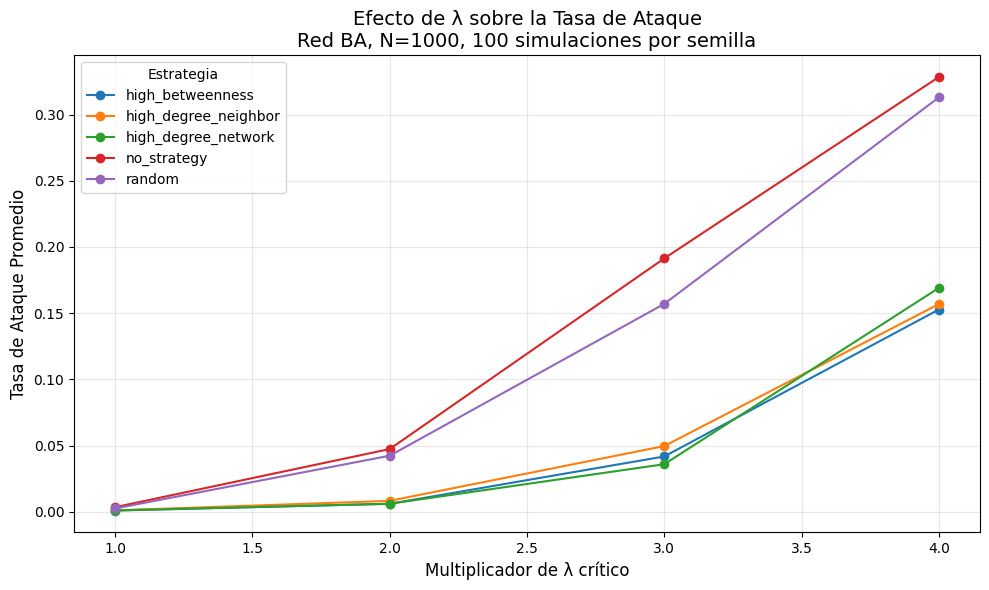

In [7]:
# Convertir a DataFrame
df_results = pd.DataFrame(results_list)

# Promediar sobre semillas
pivot_df = df_results.groupby(["lambda_mult", "strategy"])["attack_rate"].mean().unstack()

# Graficar
plt.figure(figsize=(10, 6))

for strategy_name in pivot_df.columns:
    plt.plot(
        pivot_df.index,
        pivot_df[strategy_name],
        marker='o',
        label=strategy_name
    )

plt.xlabel("Multiplicador de λ crítico", fontsize=12)
plt.ylabel("Tasa de Ataque Promedio", fontsize=12)
plt.title(
    f"Efecto de λ sobre la Tasa de Ataque\nRed {network_type}, N={N}, 100 simulaciones por semilla",
    fontsize=14
)
plt.legend(title="Estrategia")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
